In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
# json
import json
# sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# lgb
import lightgbm as lgb

# datatime
import datetime

import gc
%matplotlib inline

In [2]:
def load_df(csv_path, nrows=None):
    '''
    load csv file and convert json columns to normal columns
    '''
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in json_columns:
        column_df = pd.io.json.json_normalize(list(df[column].values))
        column_df.columns = [f'{column}.{sub_column}' for sub_column in column_df.columns]
        df = df.drop(column, axis=1).join(column_df)
        
    return df

In [3]:
# load and transform data
train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [4]:
from sklearn.model_selection import GroupKFold

def get_oof(train_df, test_df, select_features):
    
    def get_fold(train_df, kfold = 5):   
        '''
        kfold based on unique fullVisitorId
        '''
        unique_vis = np.array(sorted(train_df['fullVisitorId'].unique()))
        folds = GroupKFold(n_splits=kfold)
        fold_ids = []
        ids = np.arange(train_df.shape[0])
        for train_vis, dev_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            fold_ids.append([
                ids[train_df['fullVisitorId'].isin(unique_vis[train_vis])],
                ids[train_df['fullVisitorId'].isin(unique_vis[dev_vis])]
            ])
        return fold_ids
    
    importances = pd.DataFrame()
    train_df_y = train_df['totals.transactionRevenue'].values
    oof_pred = np.zeros(train_df.shape[0])
    test_pred = np.zeros(test_df.shape[0])
    fold_ids = get_fold(train_df)
    
    for i, (train_idx, dev_idx) in enumerate(fold_ids):
        print('processing {} fold: '.format(i))

        train_id = train_df['fullVisitorId'].iloc[train_idx].values
        train_X = train_df[select_features].iloc[train_idx]
        train_y = train_df['totals.transactionRevenue'].iloc[train_idx].values
        train_y = np.log1p(train_y)

        dev_id = train_df['fullVisitorId'].iloc[dev_idx].values
        dev_X = train_df[select_features].iloc[dev_idx]
        dev_y = train_df['totals.transactionRevenue'].iloc[dev_idx].values  
        dev_y = np.log1p(dev_y)
        
        test_id = test_df['fullVisitorId'].values
        test_X = test_df[select_features].values
        
        reg = lgb.LGBMRegressor(
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=1000,
            subsample=.9,
            colsample_bytree=.9,
            random_state=1)
        
        reg.fit(
            train_X, train_y,
            eval_set=[(dev_X, dev_y)],
            early_stopping_rounds=50,
            verbose=100,
            eval_metric='rmse')
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = select_features
        imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
        imp_df['fold'] = i + 1
        importances = pd.concat([importances, imp_df], axis=0)
        
        pred_dev = reg.predict(dev_X, num_iteration=reg.best_iteration_)
        pred_test = reg.predict(test_X, num_iteration=reg.best_iteration_)
        pred_dev[pred_dev < 0] = 0
        pred_test[pred_test < 0] = 0

        oof_pred[dev_idx] = pred_dev
        test_pred += np.expm1(pred_test) / len(fold_ids)
        
    # n fold rmse 
    oof_rmse_score = rmse(np.log1p(train_df_y), oof_pred)
    print('fold rmse:{}'.format(oof_rmse_score))
    
    return oof_pred, test_pred, importances

In [5]:
# define the metrics: rmse(root mean square error)
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

### Session level

In [6]:
num_columns = ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'visitStartTime']
cat_columns = ['channelGrouping',
               'device.browser',
               'device.deviceCategory',
               'device.operatingSystem',
               'device.isMobile',
               'geoNetwork.city',
               'geoNetwork.continent',
               'geoNetwork.country',
               'geoNetwork.metro',
               'geoNetwork.networkDomain',
               'geoNetwork.region',
               'geoNetwork.subContinent',
               'trafficSource.adContent',
               'trafficSource.campaign',
               'trafficSource.isTrueDirect',
               'trafficSource.keyword',
               'trafficSource.medium',
               'trafficSource.referralPath',
               'trafficSource.source']

In [7]:
# preprocess data, the select featrues are infered from the 
def preprocess(train_df, test_df, num_columns, cat_columns):
    # encode categorical columns
    for column in cat_columns:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
        train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
        test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))
    
    train_df[num_columns] = train_df[num_columns].fillna(0)
    train_df[num_columns] = train_df[num_columns].astype(float)
    test_df[num_columns] = test_df[num_columns].fillna(0)
    test_df[num_columns] = test_df[num_columns].astype(float)
    
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
    
    return train_df, test_df

In [8]:
train_df, test_df = preprocess(train_df, test_df, num_columns, cat_columns)

In [9]:
oof_pred, test_pred, importances = get_oof(train_df, test_df, num_columns+cat_columns)

processing 0 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65376
[200]	valid_0's rmse: 1.63823
[300]	valid_0's rmse: 1.63312
[400]	valid_0's rmse: 1.63062
[500]	valid_0's rmse: 1.62879
[600]	valid_0's rmse: 1.62832
Early stopping, best iteration is:
[643]	valid_0's rmse: 1.62802
processing 1 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63182
[200]	valid_0's rmse: 1.61938
[300]	valid_0's rmse: 1.61564
[400]	valid_0's rmse: 1.61244
Early stopping, best iteration is:
[441]	valid_0's rmse: 1.61116
processing 2 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63867
[200]	valid_0's rmse: 1.62228
[300]	valid_0's rmse: 1.61554
[400]	valid_0's rmse: 1.61161
[500]	valid_0's rmse: 1.60924
[600]	valid_0's rmse: 1.60792
Early stopping, best iteration is:
[600]	valid_0's rmse: 1.60792
processing 3 fold: 
Training until validation scores don't improve for 50 round

In [10]:
# create time series features
def create_time_features(df):
    df['visitDate'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['dow'] = df['visitDate'].dt.dayofweek
    df['hours'] = df['visitDate'].dt.hour
    df['dom'] = df['visitDate'].dt.day
    df.sort_values(['fullVisitorId', 'visitDate'], ascending=True, inplace=True)
    df['nextSession1'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
    df['nextSession2'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
    df['pageviews_per_day'] = df['date'].map(df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum())
    df['ratio_pageviews'] = df['totals.pageviews'] / df['pageviews_per_day']
    df = df.sort_index()
    return df

In [11]:
train_df, test_df = create_time_features(train_df), create_time_features(test_df)

In [12]:
additional_columns = ['dow', 'hours', 'dom', 'nextSession1', 'nextSession2', 'ratio_pageviews', 'pageviews_per_day']

In [13]:
num_columns = [num_column for num_column in num_columns if num_column != 'visitStartTime']

In [14]:
oof_pred, test_pred, importances = get_oof(train_df, test_df, num_columns+cat_columns+additional_columns)

processing 0 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.64033
[200]	valid_0's rmse: 1.62351
[300]	valid_0's rmse: 1.6179
[400]	valid_0's rmse: 1.61532
[500]	valid_0's rmse: 1.61303
[600]	valid_0's rmse: 1.61129
[700]	valid_0's rmse: 1.6095
[800]	valid_0's rmse: 1.60886
Early stopping, best iteration is:
[848]	valid_0's rmse: 1.60838
processing 1 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61646
[200]	valid_0's rmse: 1.60197
[300]	valid_0's rmse: 1.59731
[400]	valid_0's rmse: 1.59349
[500]	valid_0's rmse: 1.59248
[600]	valid_0's rmse: 1.59181
Early stopping, best iteration is:
[607]	valid_0's rmse: 1.5916
processing 2 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61963
[200]	valid_0's rmse: 1.59922
[300]	valid_0's rmse: 1.59271
[400]	valid_0's rmse: 1.58855
[500]	valid_0's rmse: 1.5865
[600]	valid_0's rmse: 1.58523
Early stopping, best iterati

In [16]:
# display feature importance
importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['feature', 'gain']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

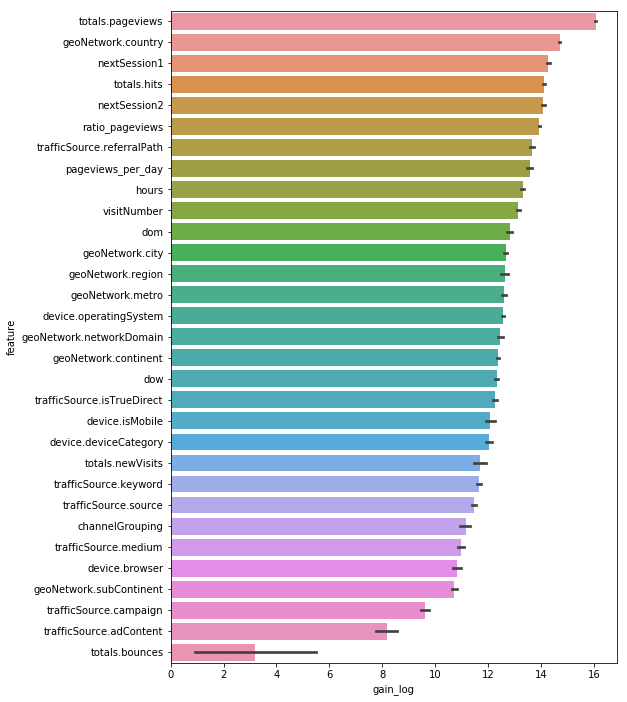

In [17]:
plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [49]:
pred_dev = pd.DataFrame()
pred_dev[['fullVisitorId', 'totals.transactionRevenue']] = train_df[['fullVisitorId', 'totals.transactionRevenue']]
pred_dev['predRevenue'] = np.expm1(oof_pred)

In [52]:
pred_dev = pred_dev.groupby('fullVisitorId')[['totals.transactionRevenue', 'predRevenue']].sum().reset_index()

In [53]:
rmse(np.log1p(pred_dev['totals.transactionRevenue']), np.log1p(pred_dev['predRevenue']))

1.595345450974619

### Visitor level

In [18]:
train_df['prediction'] = np.expm1(oof_pred)
test_df['prediction'] = test_pred

In [19]:
train_visitor = train_df[num_columns+cat_columns+additional_columns+['fullVisitorId']].groupby('fullVisitorId').mean()
train_visitor_y = train_df[['totals.transactionRevenue', 'fullVisitorId']].groupby('fullVisitorId').sum()
train_visitor = pd.concat([train_visitor, train_visitor_y], axis=1)

In [20]:
train_pred_list = train_df[['fullVisitorId', 'prediction']]\
.groupby('fullVisitorId')\
.apply(lambda x: list(x.prediction))\
.apply(lambda x: {'pred_'+str(i):pred for i, pred in enumerate(x)})

In [21]:
train_pred_df = pd.DataFrame(list(train_pred_list.values), index=train_pred_list.index)

In [22]:
train_features = train_pred_df.columns

In [23]:
def aggregate_predictions(df, pred_features):
    df['log_mean_pred'] = np.log1p(df[pred_features].mean(axis=1))
    df['log_median_pred'] = np.log1p(df[pred_features].median(axis=1))
    df['log_sum_pred'] = np.log1p(df[pred_features].fillna(0).sum(axis=1))
    df['sum_log_pred'] = np.log1p(df[pred_features]).sum(axis=1)
    df['nb_session'] = len(pred_features) - df[pred_features].isnull().sum(axis=1)
    return df

In [24]:
train_pred_df = aggregate_predictions(train_pred_df, train_features)

/home/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [25]:
train_pred_df.head()

,pred_0,pred_1,pred_10,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,...,pred_95,pred_96,pred_97,pred_98,pred_99,log_mean_pred,log_median_pred,log_sum_pred,sum_log_pred,nb_session
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1
0000020424342248747,0.058475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.056829,0.056829,0.056829,0.056829,1
0000027376579751715,0.003758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003751,0.003751,0.003751,0.003751,1
0000039460501403861,0.001630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001629,0.001629,0.001629,0.001629,1
0000040862739425590,0.000000,0.003198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001597,0.001597,0.003192,0.003192,2


In [26]:
train_visitor = pd.concat([train_visitor, train_pred_df], axis=1)

In [27]:
del train_pred_df, train_pred_list
gc.collect()

118

In [28]:
test_visitor = test_df[num_columns+cat_columns+additional_columns+['fullVisitorId']].groupby('fullVisitorId').mean()

In [29]:
test_pred_list = test_df[['fullVisitorId', 'prediction']]\
.groupby('fullVisitorId')\
.apply(lambda x: list(x.prediction))\
.apply(lambda x: {'pred_'+str(i):pred for i, pred in enumerate(x)})

In [30]:
test_pred_df = pd.DataFrame(list(test_pred_list.values), index=test_pred_list.index)

In [32]:
for i in train_features:
    if i not in test_pred_df.columns:
        test_pred_df[i] = np.nan

In [33]:
test_pred_df = aggregate_predictions(test_pred_df, train_features)

/home/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [35]:
test_visitor = pd.concat([test_visitor, test_pred_df], axis=1)

In [36]:
test_visitor.head()

,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,device.isMobile,...,pred_273,pred_274,pred_275,pred_276,pred_277,log_mean_pred,log_median_pred,log_sum_pred,sum_log_pred,nb_session
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000000259678714014,0.0,9.5,0.500000,6.5,1.5,4.0,35.0,0.0,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.211481,0.211481,0.385951,0.386056,2
0000049363351866189,1.0,1.0,0.333333,1.0,2.0,2.0,35.0,0.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.003126,0.004000,0.009349,0.009375,3
0000053049821714864,1.0,1.0,1.000000,1.0,1.0,1.0,73.0,1.0,23.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1
0000059488412965267,1.0,1.0,0.333333,1.0,2.0,2.0,35.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.002847,0.002131,0.008516,0.008536,3
0000085840370633780,0.0,2.0,1.000000,2.0,1.0,4.0,72.0,0.0,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.004336,0.004336,0.004336,0.004336,1


In [34]:
del test_pred_list, test_pred_df, train_df, test_df
gc.collect()

215

In [37]:
train_visitor = train_visitor.reset_index()
test_visitor = test_visitor.reset_index()

In [38]:
total_features = [x for x in train_visitor.columns if x not in ['fullVisitorId', 'totals.transactionRevenue']]

In [40]:
total_features = [x for x in total_features if x not in train_features]

In [42]:
train_visitor = train_visitor[total_features+['fullVisitorId', 'totals.transactionRevenue']]
test_visitor = test_visitor[total_features+['fullVisitorId']]

In [44]:
oof_pred, test_pred, importances = get_oof(train_visitor, test_visitor, total_features)

processing 0 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.5789
Early stopping, best iteration is:
[149]	valid_0's rmse: 1.5767
processing 1 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.5853
[200]	valid_0's rmse: 1.58195
Early stopping, best iteration is:
[172]	valid_0's rmse: 1.5814
processing 2 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.57644
[200]	valid_0's rmse: 1.57412
Early stopping, best iteration is:
[170]	valid_0's rmse: 1.5735
processing 3 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.56131
[200]	valid_0's rmse: 1.55878
Early stopping, best iteration is:
[206]	valid_0's rmse: 1.55874
processing 4 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.58193
[200]	valid_0's rmse: 1.58058
Early stopping, best iteration is:
[195]	valid_0's rmse: 1.5805
f

In [46]:
len(test_pred)

617242

In [49]:
len(test_visitor)

617242

In [50]:
submission = pd.read_csv('sample_submission.csv')
test_id = test_df['fullVisitorId'].values
pred_test_df = pd.DataFrame({'fullVisitorID': test_visitor['fullVisitorId'].values})
pred_test_df['predict'] = test_pred
pred_test_df = pred_test_df.groupby('fullVisitorID')['predict'].sum().reset_index()
pred_test_df['predict'] = np.log1p(pred_test_df['predict'].values)

submission = submission.merge(pred_test_df, left_on='fullVisitorId', right_on='fullVisitorID')
submission =submission.drop(['PredictedLogRevenue', 'fullVisitorID'], axis=1)
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [51]:
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.167732
1,0000049363351866189,0.004888
2,0000053049821714864,0.004744
3,0000059488412965267,0.004888
4,0000085840370633780,0.004744


In [52]:
submission.to_csv('lgb_submission.csv', index=0)